### Import necessary libraries

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

### Load & prepare time-series table

In [ ]:
# Load data and ensure Timestamp is parsed; adjust column name if different
df = pd.read_csv('data/benin.csv', parse_dates=['Timestamp'], dayfirst=False)
# If Timestamp column name differs, try common alternatives
if 'Timestamp' not in df.columns and 'timestamp' in df.columns:
    df.rename(columns={'timestamp':'Timestamp'}, inplace=True)
# Set Timestamp as index for time-series operations
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
# Quick sanitize: coerce numeric columns (if strings are present)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# Attempt to coerce obvious numeric-like columns that may be object dtype
for c in df.columns:
    if df[c].dtype == 'object' and c not in ['Timestamp']:
        df[c] = pd.to_numeric(df[c], errors='ignore') # type: ignore
# Add helper time columns
df['month'] = df['Timestamp'].dt.month
df['hour'] = df['Timestamp'].dt.hour
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,month,hour
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,...,122.1,0.0,998,0,0.0,26.3,26.2,NaN,8,0
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,...,0.0,0.0,998,0,0.0,26.3,26.2,NaN,8,0
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,...,124.6,1.5,997,0,0.0,26.4,26.2,NaN,8,0
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,...,120.3,1.3,997,0,0.0,26.4,26.3,NaN,8,0
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,...,113.2,1.0,997,0,0.0,26.4,26.3,NaN,8,0


### Summary statistics for numeric columns

In [23]:
display(df.describe())

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,month,hour,wd_mod
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,...,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0,525600.000000,525600.000000,525600.000000
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,...,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN,6.526027,11.500000,153.418049
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,...,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN,1.000000,0.000000,0.000000
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,...,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN,4.000000,5.750000,59.000000
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,...,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN,7.000000,11.500000,181.000000
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,...,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN,10.000000,17.250000,235.100000
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,...,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN,12.000000,23.000000,359.900000
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,...,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN,3.447855,6.922193,102.328395


### Missing values per column

In [24]:

missing = df.isna().sum()
display(missing.sort_values(ascending=False))
# List columns with >5% missing
pct_missing = (missing / len(df)) * 100
cols_over_5pct = pct_missing[pct_missing > 5].sort_values(ascending=False)
print('Columns with >5% missing (column: % missing)')
print(cols_over_5pct)


Comments         525600
Timestamp             0
DNI                   0
GHI                   0
ModA                  0
ModB                  0
Tamb                  0
DHI                   0
RH                    0
WS                    0
WSstdev               0
WSgust                0
WDstdev               0
BP                    0
Cleaning              0
WD                    0
Precipitation         0
TModA                 0
TModB                 0
month                 0
hour                  0
outlier_flag          0
wd_mod                0
wd_bin                0
dtype: int64

Columns with >5% missing (column: % missing)
Comments    100.0
dtype: float64


### Handle missing values

In [25]:

# For key sensor/irradiance and wind columns we will impute median values if missing
key_cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust','Tamb','RH']
# Keep only columns that exist in the dataframe
key_cols = [c for c in key_cols if c in df.columns]
# Report how many would be imputed
impute_info = df[key_cols].isna().sum()
print('Missing in key columns before imputation:')
print(impute_info[impute_info>0])
# Impute median for key columns
for c in key_cols:
    if df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)

print('\nMissing after imputation (should be 0 for key cols):')
print(df[key_cols].isna().sum())


Missing in key columns before imputation:
Series([], dtype: int64)

Missing after imputation (should be 0 for key cols):
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
Tamb      0
RH        0
dtype: int64


### Outlier detection using z-scores for selected columns

In [26]:
from scipy import stats
cols_for_z = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
cols_for_z = [c for c in cols_for_z if c in df.columns]

z_scores = pd.DataFrame()
for c in cols_for_z:
    z_scores[c] = stats.zscore(df[c].dropna())

# Align z-scores with df index (dropna changed indexing)
z_scores = z_scores.reindex(df.index)

# Flag rows where any |z|>3
outlier_mask = (z_scores.abs() > 3).any(axis=1)
print('Outliers detected:', outlier_mask.sum())
# Add column to df
df['outlier_flag'] = outlier_mask
# Optionally drop or inspect outliers

# Provide the rows (first 10) that are flagged
display(df.loc[df['outlier_flag'], cols_for_z].head(10))


Outliers detected: 7740


,GHI,DNI,DHI,ModA,ModB,WS,WSgust
670,836.0,235.0,610.6,778.8,783.8,3.2,4.1
671,1274.0,698.8,615.2,1210.3,1210.3,3.4,4.1
672,938.0,340.1,612.8,891.1,891.1,3.4,4.6
673,718.5,126.8,593.2,682.6,682.6,4.7,5.6
674,1349.0,771.8,618.0,1281.5,1281.5,4.0,4.6
675,792.6,169.5,625.4,753.0,753.0,3.6,4.4
676,1334.0,751.9,620.0,1267.3,1267.3,2.7,3.6
677,943.0,351.5,602.8,846.0,850.0,3.1,4.1
717,758.9,149.2,601.2,709.9,713.8,3.1,3.9
718,632.8,23.0,603.3,587.0,591.0,3.0,4.1


### Save cleaned data

In [27]:
import os
os.makedirs('data', exist_ok=True)
clean_path = 'data/benin_clean.csv'
# Save without committing to git; ensure data/ is gitignored
df.to_csv(clean_path, index=False)
print(f"Saved cleaned data to {clean_path}")


Saved cleaned data to data/benin_clean.csv


### Time series plots: GHI, DNI, DHI, Tamb vs Timestamp

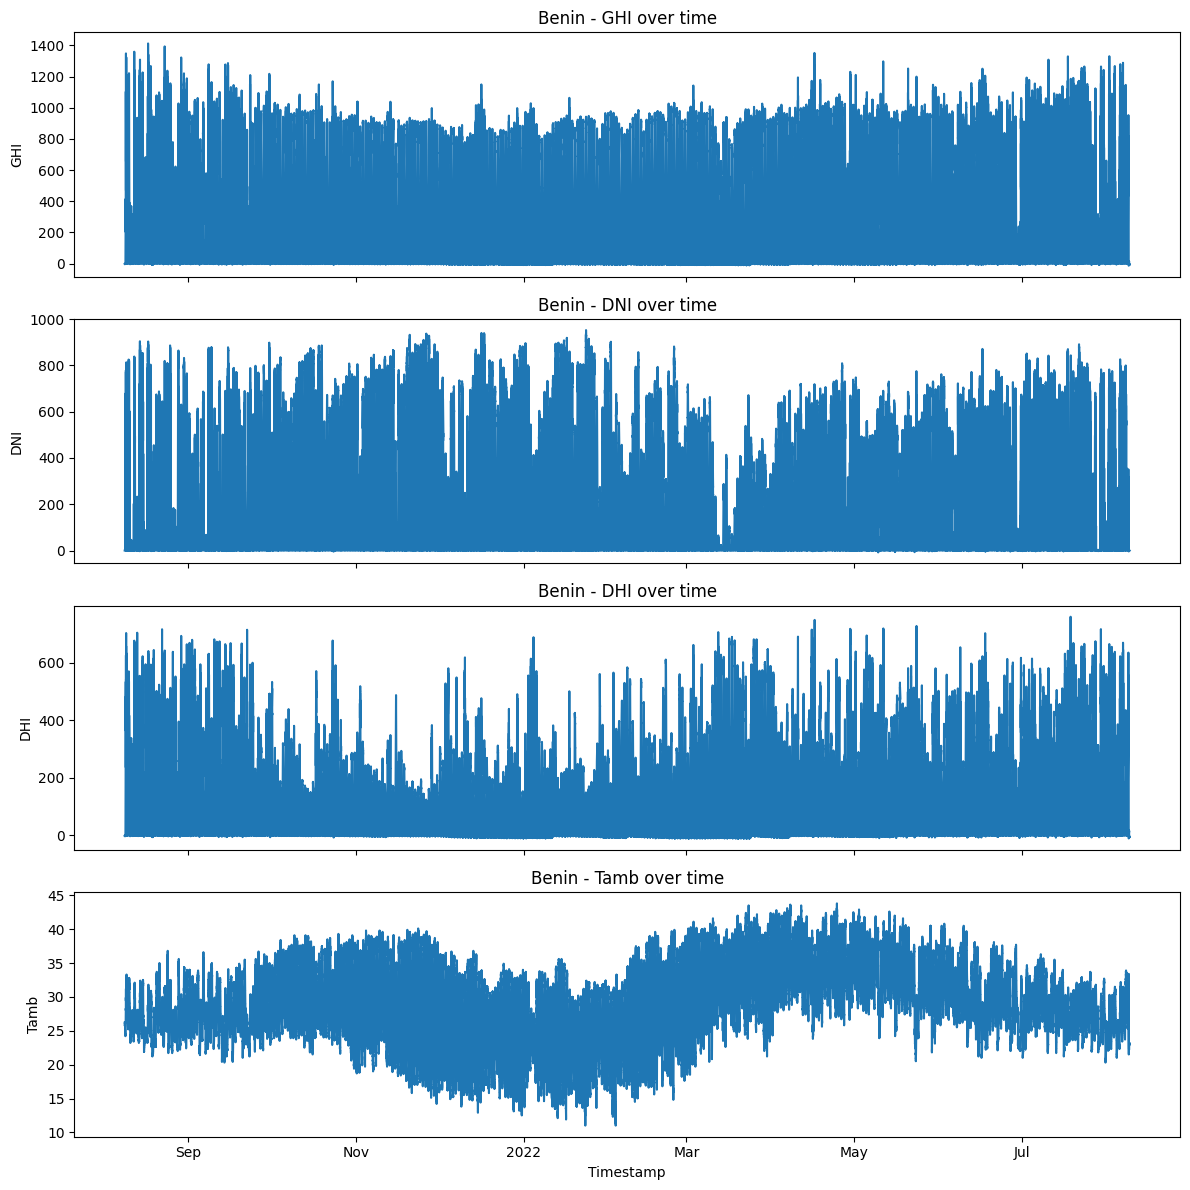

In [28]:
import matplotlib.dates as mdates
plot_cols = [c for c in ['GHI','DNI','DHI','Tamb'] if c in df.columns]
if len(plot_cols) == 0:
    print('No common columns (GHI/DNI/DHI/Tamb) found to plot.')
else:
    fig, axes = plt.subplots(len(plot_cols), 1, figsize=(12, 3*len(plot_cols)), sharex=True)
    if len(plot_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, plot_cols):
        sns.lineplot(x='Timestamp', y=col, data=df, ax=ax)
        ax.set_title(f'Benin - {col} over time')
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.tight_layout()
    plt.show()


### Comprehensive analysis: cleaning impact, correlations, scatter plots, wind rose, histograms, temperature analysis, and bubble chart

In [29]:
# Cleaning impact: compare ModA & ModB averages for rows that had missing key values vs those that didn't
plot_cols = [c for c in ['ModA','ModB'] if c in df.columns]
if 'was_missing_key' in df.columns:
    if plot_cols:
        means = df.groupby('was_missing_key')[plot_cols].mean()
        display(means)
        means.plot(kind='bar', figsize=(8,4), title='Average ModA/ModB: rows with missing key cols (True) vs clean (False)')
        plt.xlabel('was_missing_key')
        plt.show()
    else:
        print('No ModA/ModB columns found.')
else:
    print('No was_missing_key flag found (it would indicate rows that had missing key cols before imputation).')

No was_missing_key flag found (it would indicate rows that had missing key cols before imputation).


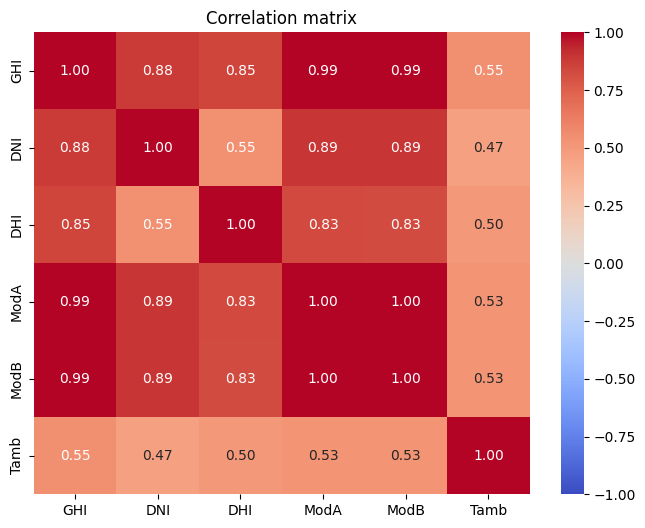

In [30]:
# Correlation heatmap for selected variables
corr_cols = [c for c in ['GHI','DNI','DHI','ModA','ModB','Tamb'] if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation matrix')
    plt.show()
else:
    print('Not enough columns for correlation heatmap:', corr_cols)

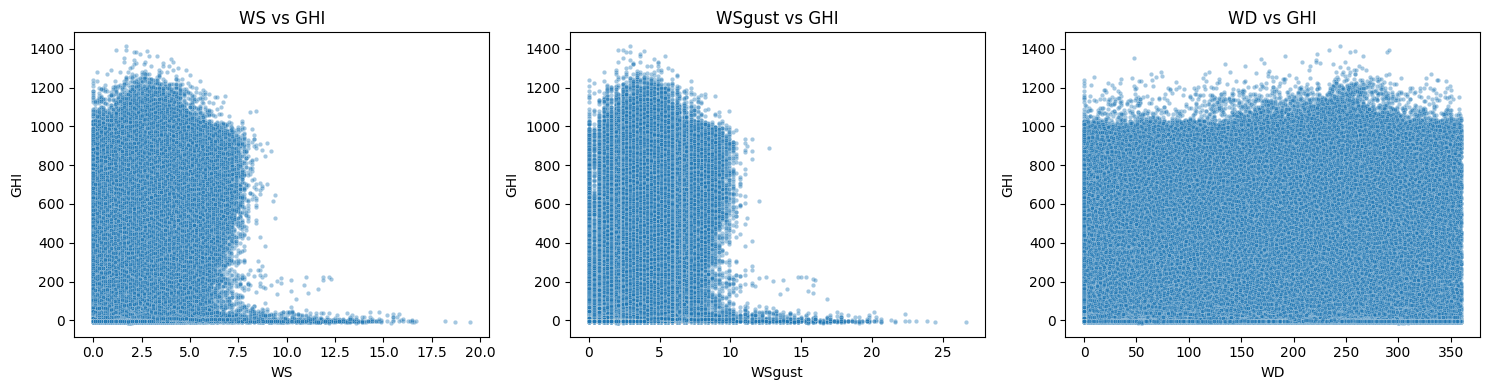

In [31]:
# Scatter plots: WS, WSgust, WD vs GHI and RH relationships
scatter_x = [c for c in ['WS','WSgust','WD'] if c in df.columns]
if 'GHI' in df.columns and scatter_x:
    fig, axes = plt.subplots(1, len(scatter_x), figsize=(5*len(scatter_x),4))
    if len(scatter_x)==1: axes=[axes]
    for ax, x in zip(axes, scatter_x):
        sns.scatterplot(x=x, y='GHI', data=df, ax=ax, alpha=0.4, s=10)
        ax.set_title(f'{x} vs GHI')
    plt.tight_layout()
    plt.show()
else:
    print('Missing GHI or wind columns for scatter plots.')

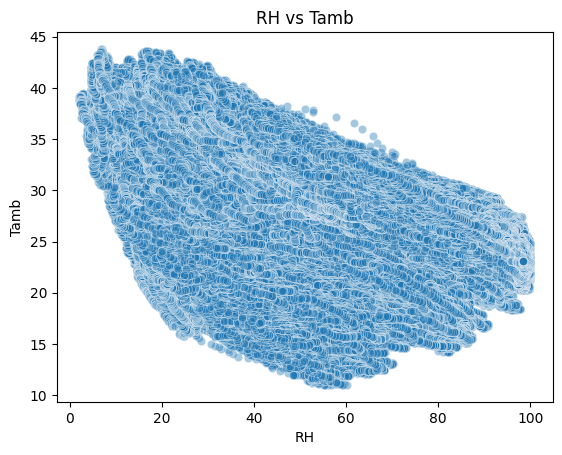

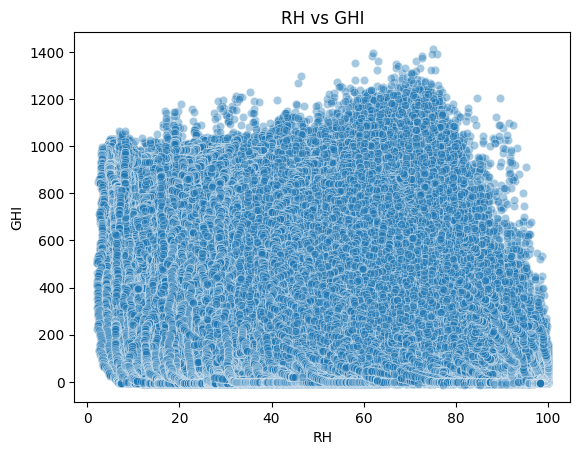

In [32]:
# RH vs Tamb and RH vs GHI
if 'RH' in df.columns:
    if 'Tamb' in df.columns:
        sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.4)
        plt.title('RH vs Tamb')
        plt.show()
    if 'GHI' in df.columns:
        sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.4)
        plt.title('RH vs GHI')
        plt.show()
else:
    print('RH column not found for RH-related plots.')

C:\Users\BIOS\AppData\Local\Temp\ipykernel_10392\3240709188.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rose = df.groupby('wd_bin')[ws_col].mean().reset_index()


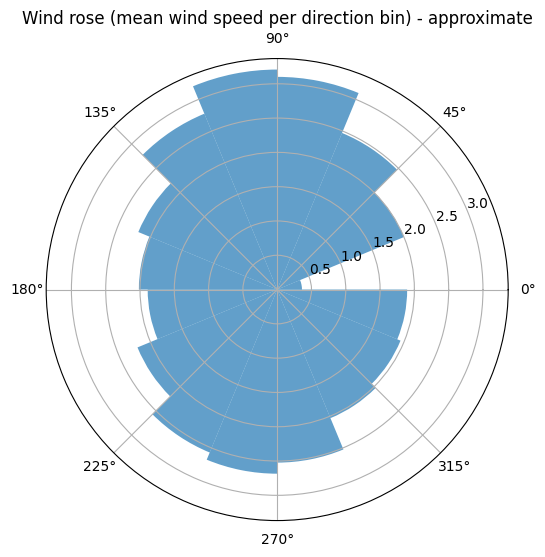

In [33]:
# Wind rose (approximation) - radial bar plot by wind direction bins showing mean wind speed
if 'WD' in df.columns and ('WS' in df.columns or 'WSgust' in df.columns):
    ws_col = 'WS' if 'WS' in df.columns else 'WSgust'
    bins = np.arange(0,360,22.5)  # 16 bins
    df['wd_mod'] = df['WD'] % 360
    df['wd_bin'] = pd.cut(df['wd_mod'], bins=np.append(bins,360), include_lowest=True, right=False)
    rose = df.groupby('wd_bin')[ws_col].mean().reset_index()
    # convert bin labels to angles (midpoint)
    def bin_mid_angle(b):
        left = b.left
        right = b.right
        return np.deg2rad((left + right)/2)
    angles = rose['wd_bin'].apply(bin_mid_angle)
    values = rose[ws_col].fillna(0).values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    bars = ax.bar(angles, values, width=np.deg2rad(22.5), bottom=0.0, align='center', alpha=0.7)
    ax.set_title('Wind rose (mean wind speed per direction bin) - approximate')
    plt.show()
else:
    print('Not enough wind columns (WD and WS/WSgust) for wind rose.')

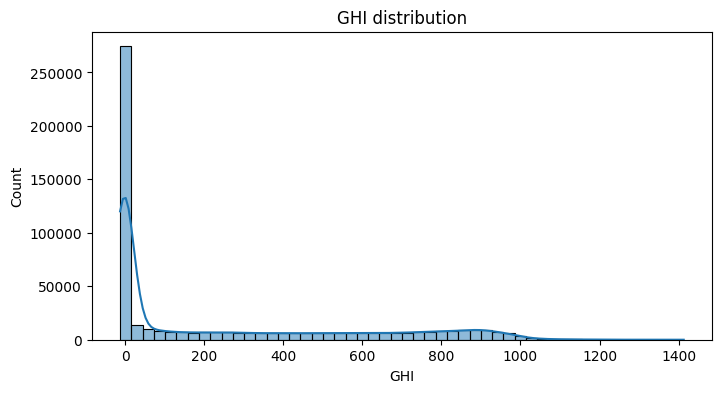

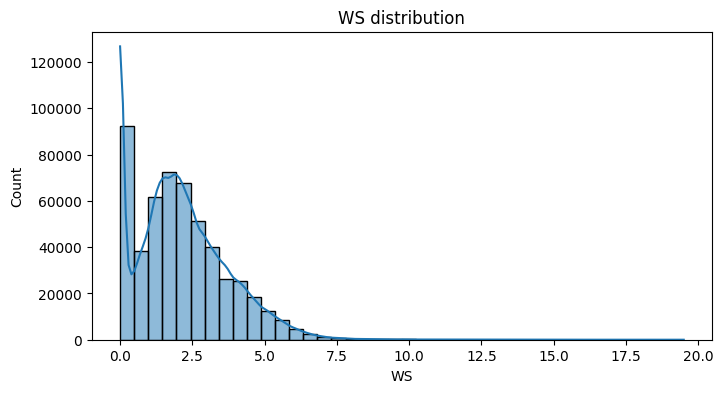

In [34]:
# Histograms for GHI and WS
if 'GHI' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['GHI'].dropna(), bins=50, kde=True)
    plt.title('GHI distribution')
    plt.show()
if 'WS' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['WS'].dropna(), bins=40, kde=True)
    plt.title('WS distribution')
    plt.show()

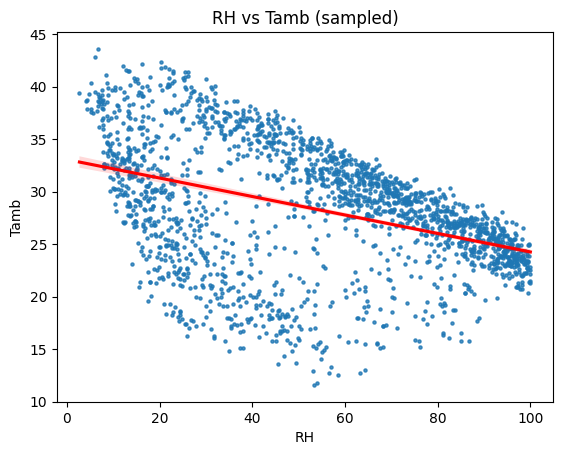

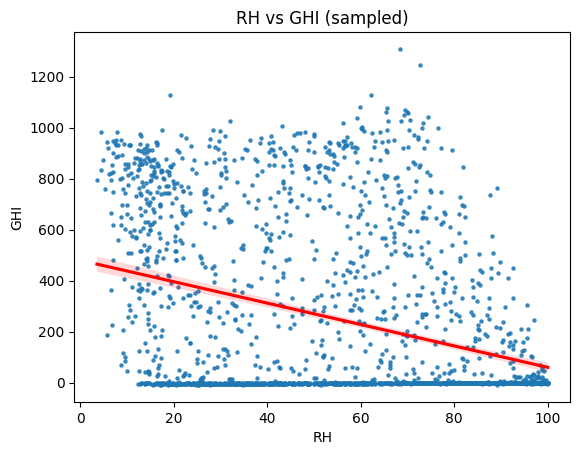

In [35]:
# Temperature analysis: RH influence on Tamb and GHI (use sampling for large datasets)
if 'RH' in df.columns and 'Tamb' in df.columns:
    samp = df.sample(n=min(2000, len(df))) if len(df)>2000 else df
    sns.regplot(x='RH', y='Tamb', data=samp, scatter_kws={'s':5}, line_kws={'color':'red'})
    plt.title('RH vs Tamb (sampled)')
    plt.show()
if 'RH' in df.columns and 'GHI' in df.columns:
    samp = df.sample(n=min(2000, len(df))) if len(df)>2000 else df
    sns.regplot(x='RH', y='GHI', data=samp, scatter_kws={'s':5}, line_kws={'color':'red'})
    plt.title('RH vs GHI (sampled)')
    plt.show()

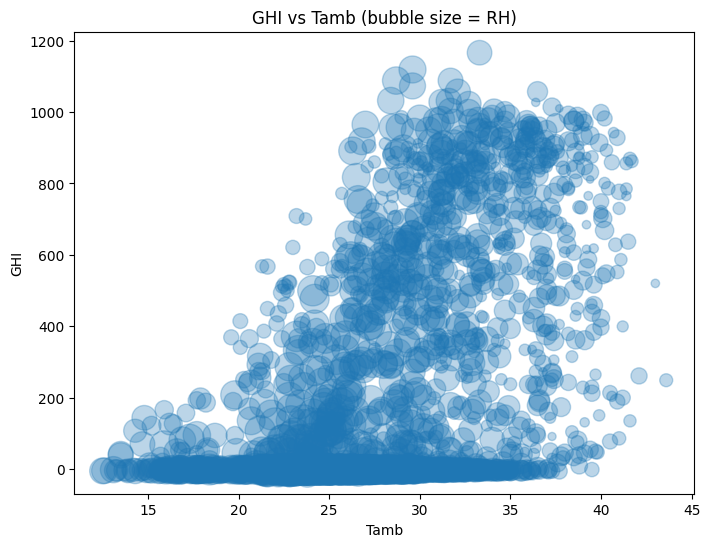

In [37]:
# Bubble chart: GHI vs Tamb, bubble size = RH (or BP if RH missing)
size_col = 'RH' if 'RH' in df.columns else ('BP' if 'BP' in df.columns else None)
if 'GHI' in df.columns and 'Tamb' in df.columns and size_col:
    sample = df.sample(n=min(2000, len(df))) if len(df) > 2000 else df
    plt.figure(figsize=(8,6))
    plt.scatter(sample['Tamb'], sample['GHI'], s=(sample[size_col].fillna(0)+1)*5, alpha=0.3)
    plt.xlabel('Tamb'); plt.ylabel('GHI'); plt.title(f'GHI vs Tamb (bubble size = {size_col})')
    plt.show()
else:
    print('Not enough columns for bubble chart (need GHI, Tamb, and RH or BP).')
